In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
data=pd.read_csv("data_encoded.csv")

In [6]:
data

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,False,True
1,18.0,33.770,1.0,2,1725.55230,True,False
2,28.0,33.000,3.0,2,4449.46200,True,False
3,33.0,22.705,0.0,1,21984.47061,True,False
4,32.0,28.880,0.0,1,3866.85520,True,False
...,...,...,...,...,...,...,...
1320,50.0,30.970,3.0,1,10600.54830,True,False
1321,18.0,31.920,0.0,0,2205.98080,False,False
1322,18.0,36.850,0.0,2,1629.83350,False,False
1323,21.0,25.800,0.0,3,2007.94500,False,False


In [9]:
print(data.shape)


(1325, 7)


In [12]:
data.head()

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,False,True
1,18.0,33.770,1.0,2,1725.55230,True,False
2,28.0,33.000,3.0,2,4449.46200,True,False
3,33.0,22.705,0.0,1,21984.47061,True,False
4,32.0,28.880,0.0,1,3866.85520,True,False


In [13]:
bool_cols = data.select_dtypes(include=["bool"]).columns.tolist()
data[bool_cols] = data[bool_cols].astype(int)

In [14]:
TARGET = "charges"
assert TARGET in data.columns, f"Missing {TARGET}."

X = data.drop(columns=[TARGET]).copy()
y = data[TARGET].values


In [15]:
from sklearn.model_selection import train_test_split

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1060, 6), (265, 6))

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="drop"
)
num_cols


['age', 'bmi', 'children', 'region', 'sex_male', 'smoker_yes']

elastic_net


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

baseline = Pipeline([
    ("prep", preprocess),
    ("model", ElasticNet(alpha=0.05, l1_ratio=0.5, max_iter=10000, random_state=42))
])

baseline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'region', 'sex_male',
                                                   'smoker_yes'])])),
                ('model',
                 ElasticNet(alpha=0.05, max_iter=10000, random_state=42))])

evaluation  helper(from chat)

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_on_original_scale(pipeline, X_te, y_te_log):
    y_pred_log = pipeline.predict(X_te)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_te_log)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "R2": r2, "y_true": y_true, "y_pred": y_pred}


In [24]:
baseline_metrics = evaluate_on_original_scale(baseline, X_test, y_test)
baseline_metrics

{'RMSE': np.float64(8060.401114087055),
 'MAE': 4215.011269579035,
 'R2': 0.49082592144458914,
 'y_true': array([19798.05455,  2497.0383 , 13555.0049 , 10436.096  ,  5227.98875,
         1622.1885 ,  2150.469  ,  6474.013  ,  6652.5288 , 42112.2356 ,
         4137.5227 , 14711.7438 ,  9290.1395 ,  3981.9768 , 21344.8467 ,
         1391.5287 , 14358.36437, 23082.95533,  3925.7582 , 17942.106  ,
         5846.9176 , 23568.272  ,  9872.701  ,  2128.43105,  8413.46305,
        12485.8009 , 16115.3045 ,  3906.127  , 19214.70553, 13831.1152 ,
        24059.68019, 12347.172  ,  9644.2525 , 14418.2804 , 35160.13457,
        14119.62   ,  1261.859  , 15170.069  ,  8334.5896 ,  8782.469  ,
         2211.13075,  4433.3877 , 21195.818  ,  6196.448  , 11381.3254 ,
        10806.839  ,  9140.951  ,  1242.816  ,  6600.361  ,  1964.78   ,
         7348.142  , 24476.47851,  6571.02435,  3353.284  ,  5253.524  ,
        24915.04626, 39983.42595, 20630.28351, 12269.68865,  3180.5101 ,
        10965.446  

In [25]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400, max_depth=12, random_state=42, n_jobs=-1
    ))
])

hgb = Pipeline([
    ("prep", preprocess),
    ("model", HistGradientBoostingRegressor(
        max_depth=8, learning_rate=0.05, random_state=42
    ))
])

rf.fit(X_train, y_train)
hgb.fit(X_train, y_train)

rf_metrics  = evaluate_on_original_scale(rf,  X_test, y_test)
hgb_metrics = evaluate_on_original_scale(hgb, X_test, y_test)

pd.DataFrame([
    {"model":"ElasticNet", **{k:v for k,v in baseline_metrics.items() if k in ["RMSE","MAE","R2"]}},
    {"model":"RandomForest", **{k:v for k,v in rf_metrics.items() if k in ["RMSE","MAE","R2"]}},
    {"model":"HistGradientBoosting", **{k:v for k,v in hgb_metrics.items() if k in ["RMSE","MAE","R2"]}},
]).sort_values("RMSE")


,model,RMSE,MAE,R2
2,HistGradientBoosting,5712.626885,2678.784138,0.744245
1,RandomForest,5924.663313,2911.097760,0.724907
0,ElasticNet,8060.401114,4215.011270,0.490826


In [27]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform, loguniform

cv = KFold(n_splits=3, shuffle=True, random_state=42)
rf_space = {
    "model__n_estimators": randint(200, 700),
    "model__max_depth": randint(6, 20),
    "model__min_samples_split": randint(2, 12),
    "model__min_samples_leaf": randint(1, 8),
    "model__max_features": uniform(0.4, 0.5),
}
rf_search = RandomizedSearchCV(
    rf, rf_space, n_iter=15, scoring="neg_root_mean_squared_error",
    cv=cv, random_state=42, n_jobs=-1, refit=True, verbose=1
)
rf_search.fit(X_train, y_train)
hgb_space = {
    "model__learning_rate": loguniform(1e-3, 0.3),
    "model__max_depth": randint(3, 12),
    "model__max_leaf_nodes": randint(15, 63),
    "model__min_samples_leaf": randint(5, 50),
    "model__l2_regularization": loguniform(1e-6, 1.0),
}
hgb_search = RandomizedSearchCV(
    hgb, hgb_space, n_iter=20, scoring="neg_root_mean_squared_error",
    cv=cv, random_state=42, n_jobs=-1, refit=True, verbose=1
)
hgb_search.fit(X_train, y_train)

rf_tuned_metrics  = evaluate_on_original_scale(rf_search.best_estimator_,  X_test, y_test)
hgb_tuned_metrics = evaluate_on_original_scale(hgb_search.best_estimator_, X_test, y_test)

pd.DataFrame([
    {"model":"RF (tuned)",  **{k:v for k,v in rf_tuned_metrics.items()  if k in ["RMSE","MAE","R2"]}},
    {"model":"HGB (tuned)", **{k:v for k,v in hgb_tuned_metrics.items() if k in ["RMSE","MAE","R2"]}},
]).sort_values("RMSE"), rf_search.best_params_, hgb_search.best_params_


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


(         model         RMSE          MAE        R2
 0   RF (tuned)  5696.146836  2635.914554  0.745718
 1  HGB (tuned)  5764.127164  2734.759031  0.739613,
 {'model__max_depth': 12,
  'model__max_features': np.float64(0.7982714934301165),
  'model__min_samples_leaf': 7,
  'model__min_samples_split': 9,
  'model__n_estimators': 388},
 {'model__l2_regularization': np.float64(0.023661540064603175),
  'model__learning_rate': np.float64(0.08138233922650512),
  'model__max_depth': 7,
  'model__max_leaf_nodes': 56,
  'model__min_samples_leaf': 43})

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

linreg = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
linreg_metrics = evaluate_on_original_scale(linreg, X_test, y_test)
linreg_metrics


{'RMSE': np.float64(8129.978066107839),
 'MAE': 4342.308625875494,
 'R2': 0.481997655712201,
 'y_true': array([19798.05455,  2497.0383 , 13555.0049 , 10436.096  ,  5227.98875,
         1622.1885 ,  2150.469  ,  6474.013  ,  6652.5288 , 42112.2356 ,
         4137.5227 , 14711.7438 ,  9290.1395 ,  3981.9768 , 21344.8467 ,
         1391.5287 , 14358.36437, 23082.95533,  3925.7582 , 17942.106  ,
         5846.9176 , 23568.272  ,  9872.701  ,  2128.43105,  8413.46305,
        12485.8009 , 16115.3045 ,  3906.127  , 19214.70553, 13831.1152 ,
        24059.68019, 12347.172  ,  9644.2525 , 14418.2804 , 35160.13457,
        14119.62   ,  1261.859  , 15170.069  ,  8334.5896 ,  8782.469  ,
         2211.13075,  4433.3877 , 21195.818  ,  6196.448  , 11381.3254 ,
        10806.839  ,  9140.951  ,  1242.816  ,  6600.361  ,  1964.78   ,
         7348.142  , 24476.47851,  6571.02435,  3353.284  ,  5253.524  ,
        24915.04626, 39983.42595, 20630.28351, 12269.68865,  3180.5101 ,
        10965.446  , 

In [29]:
# Choose the best by RMSE
candidates = {
    "ElasticNet": baseline,
    "RandomForest": rf,
    "HistGradientBoosting": hgb,

    "RF_tuned": rf_search.best_estimator_,
    "HGB_tuned": hgb_search.best_estimator_,
}

metrics = {}
for name, pipe in candidates.items():
    m = evaluate_on_original_scale(pipe, X_test, y_test)
    metrics[name] = {k:v for k,v in m.items() if k in ["RMSE","MAE","R2"]}

score_table = pd.DataFrame([
    {"model": name, **vals} for name, vals in metrics.items()
]).sort_values("RMSE")

best_name = score_table.iloc[0]["model"]
best_model = candidates[best_name]
score_table, best_name


(                  model         RMSE          MAE        R2
 3              RF_tuned  5696.146836  2635.914554  0.745718
 2  HistGradientBoosting  5712.626885  2678.784138  0.744245
 4             HGB_tuned  5764.127164  2734.759031  0.739613
 1          RandomForest  5924.663313  2911.097760  0.724907
 0            ElasticNet  8060.401114  4215.011270  0.490826,
 'RF_tuned')

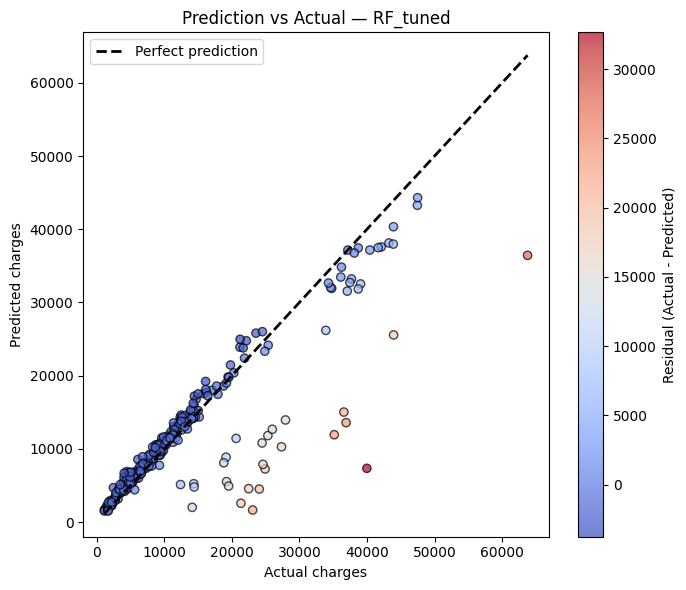

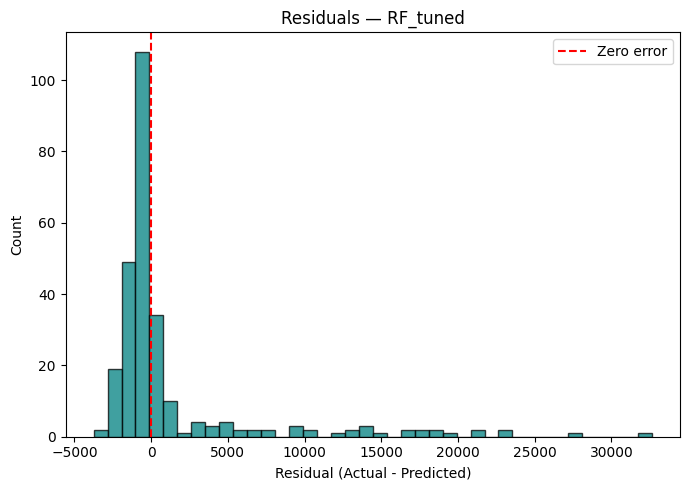

In [31]:
import matplotlib.pyplot as plt

eval_res = evaluate_on_original_scale(best_model, X_test, y_test)
y_true = eval_res["y_true"]
y_pred = eval_res["y_pred"]
residuals = y_true - y_pred

# --- Prediction vs Actual ---
plt.figure(figsize=(7,6))
scatter = plt.scatter(
    y_true, y_pred,
    c=residuals,
    cmap="coolwarm",
    alpha=0.7, edgecolor="k"
)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         "k--", lw=2, label="Perfect prediction")
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title(f"Prediction vs Actual — RF_tuned")
cbar = plt.colorbar(scatter)
cbar.set_label("Residual (Actual - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Residuals distribution ---
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40, color="teal", alpha=0.75, edgecolor="black")
plt.axvline(0, color="red", linestyle="--", label="Zero error")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title(f"Residuals — {best_name}")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring="neg_root_mean_squared_error"
)

importances = pd.DataFrame({
    "feature": num_cols,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)
importances


,feature,importance_mean,importance_std
5,smoker_yes,0.588569,0.038776
0,age,0.412776,0.044154
2,children,0.054922,0.012856
1,bmi,0.047979,0.006029
3,region,0.009055,0.004986
4,sex_male,0.000287,0.002543


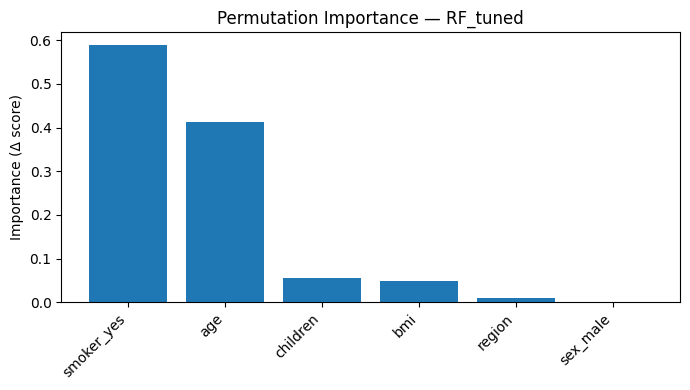

In [33]:
plt.figure(figsize=(7,4))
plt.bar(importances["feature"], importances["importance_mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance (Δ score)")
plt.title(f"Permutation Importance — {best_name}")
plt.tight_layout()
plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [35]:
!git config --global user.email "dhia.romd1@gmail.com"

In [36]:
!git config --global user.name "dhia10"

In [43]:
%cd /content

/content


In [44]:
!git clone https://github.com/yosriawedi/ML-Project-Insurance.git

Cloning into 'ML-Project-Insurance'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 992.05 KiB | 4.08 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [45]:
%cd ML-Project-Insurance

/content/ML-Project-Insurance


In [46]:
!git checkout -b modelisation-attempt

Switched to a new branch 'modelisation-attempt'


In [47]:
import shutil

src = "/content/drive/Drive/first_attempt.ipynb"   # notebook in your Drive
dst = "/content/ML-Project-Insurance/first_attempt.ipynb"
shutil.copy(src, dst)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/first_attempt.ipynb'